In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyomo.core.base.objective import minimize
from pyomo.environ import ConcreteModel, AbstractModel, Var, Objective, Constraint, ConstraintList, SolverFactory
from pyomo.environ import maximize, Binary, RangeSet, Set, NonNegativeReals, Reals

from utils import *

In [2]:
protein_sequence = "HPPHHHPHHPPPHH" #"HPPHHHPHPHPPHHPHHH"
protein_binary_sequence = get_binary_string(protein_sequence)

print("Protein sequence:", protein_sequence)
print("Protein binary sequence:", protein_binary_sequence)
n = len(protein_sequence)
print("Protein length:", n)

print("Offset: ", calculate_offset(protein_binary_sequence))

Protein sequence: HPPHHHPHHPPPHH
Protein binary sequence: 10011101100011
Protein length: 14
Offset:  4


## Basic Model
This model is from the chapter 7 of the book

In [25]:
def ILP_basic_formulation(binary_seq):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    grid_size = n*n
    offset = calculate_offset(binary_seq)

    # Set of indices
    model.I = RangeSet(0, n - 1)    # character in the sequence index
    model.I1 = RangeSet(0, n - 2)
    model.P = RangeSet(0, grid_size - 1)    # point on grid index
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision variables
    model.x = Var(model.I, model.P, within=Binary)
    model.h = Var(model.P, within=Binary)
    model.c = Var(model.P, model.P, within=Binary) 


    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    # Each amino acid in the sequence is assigned to exactly one point on the grid
    for i in model.I:
        model.constraints.add(expr = ( sum( model.x[i, p] for p in model.P ) == 1 ) )
    
    # Each point on the grid is assigned at most one amino acid in the sequence
    for i in model.I:
        for j in model.I:
            for p in model.P:
                if i != j:
                    model.constraints.add(expr = ( model.x[i, p] + model.x[j, p] <= 1 ) )
    
    # Adjacent amino acids in the sequence are assigned to neighboring points on the grid
    for i in model.I1:
        for p in model.P:
            model.constraints.add(expr = ( model.x[i, p] <= sum( model.x[i+1, q] for q in neighboring_set(p, n) ) ) )

    # Constraints to detect contacts, i.e. edges (p,q) on the grid where neighboring points p and q
    # have been assigned non-adiancent characters in the sequence with value 1
    for p in model.P:
        model.constraints.add(expr = ( model.h[p] == sum( model.x[i, p] for i in model.H ) ) )
    for p in model.P:
        for q in model.P:
            if p != q:
                model.constraints.add(expr = ( model.h[p] + model.h[q] >= 2*model.c[p, q] ) )

    
    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.c[p, q] for p in model.P for q in model.P ) - offset ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", [[model.x[i, p]() for p in model.P] for i in model.I]) 
    else:
        print('Error in solving the model')

    return [[model.x[i, p]() for p in model.P] for i in model.I]



x = ILP_basic_formulation(protein_binary_sequence)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpl8hglp9p.pyomo.lp
Reading time = 0.01 seconds
x4673: 8137 rows, 4673 columns, 22261 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 8137 rows, 4673 columns and 22261 nonzeros
Model fingerprint: 0x6468b256
Variable types: 1 continuous, 4672 integer (4672 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 5545 rows and 2089 columns
Presolve time: 0.03s
Presolved: 2592 rows, 2584 columns, 9517 nonzeros
Variable types: 0 continuous, 2584 integer (2584 binary)
Found heuristic solution: objective 82.0000000

Root relaxation: objective 3.77000

[0, 8, 9, 1, 2, 3, 4, 5]


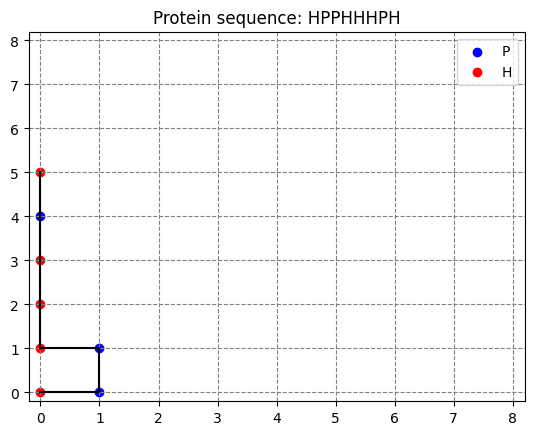

In [26]:
positions = []
pos = []
for i in range(len(x)):
    for p in range(len(x[i])):
        if x[i][p] == 1:
            positions.append((p // n, p % n))
            pos.append(p)
print(pos)

plot_folding(protein_binary_sequence, protein_sequence, positions, n)

## Graph Model
This model is from the paper

In [11]:
def ILP_graph_formulation(binary_seq, grid_size, additional_constr, reduced, formulation=""):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    G = build_graph(binary_seq, grid_size=grid_size, reduced=reduced) # graph

    # Set of indices
    model.K = RangeSet(0, n - 1)    # set of indexes in sequence 
    model.K1 = RangeSet(0, n - 2)
    model.I = RangeSet(0, grid_size) 
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision Variables
    model.x = Var(model.K, model.I, model.I, within=Binary)
    model.y = Var(model.I, model.I, model.I, model.I, within=Binary)


    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    if formulation != "alternative":
        # the first amino acid is placed on the center of the grid (n,n)
        model.constraints.add(expr = ( model.x[0, n, n] == 1 ) )
    # in the alternative formulation we'll see later we don't have this constraint

    # each vertex has at most one amino acid
    for i in model.I:
        for j in model.I:
            model.constraints.add(expr = ( sum( model.x[k, i, j] for k in model.K ) <= 1 ) )
        
    # each amino acid is placed at exactly one vertex
    for k in model.K:
        model.constraints.add(expr = ( sum( model.x[k, i, j] for i in model.I for j in model.I ) == 1 ) )

    # if amino acid k is placed at (i, j) then amino acid k+1 is placed at a vertex (u, v) adjacent
    # to vertex (i, j)
    for k in model.K1:
        for i in model.I:
            for j in model.I:
                try:
                    model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+1, u, v] for (u, v) in G[(i,j)] ) ) )
                except:
                    # if node is not in edges
                    pass
    

    # we want y[i, j ,u, v]=1 only if an H amino acid is placed at (i,j) and another amino acid H is placed at a neighboring vertex
    for ((i, j), (u, v)) in G.edges():
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, i, j] for k in model.H ) ) )
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, u, v] for k in model.H ) ) )

    # Additional Constraints
    # ensure that if k is placed on (i, j) then k+t (or k-t) must be placed on a vertex with distance <= t from (i, j)
    if additional_constr:
        for t in model.K:
            for i in model.I:
                for j in model.I:
                    for k in range(0, n - t):
                        model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+t, u, v] for (u, v) in get_neighbours(G, i, j, t, reduced=reduced) ) ) )
                    for k in range(t, n):
                        model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k-t, u, v] for (u, v) in get_neighbours(G, i, j, t, reduced=reduced) ) ) )


    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.y[i, j, u, v] for ((i, j), (u, v)) in G.edges() ) ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", ) 
    else:
        print('Error in solving the model')
    
    return [[[model.x[k, i, j]() for j in model.I] for i in model.I] for k in model.K]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpubkicwt3.pyomo.lp
Reading time = 0.02 seconds
x625633: 7118 rows, 11679 columns, 57756 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 7118 rows, 11679 columns and 57756 nonzeros
Model fingerprint: 0x59b472d1
Variable types: 1 continuous, 11678 integer (11678 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 4.0000000
Presolve removed 1946 rows and 4310 columns
Presolve time: 0.48s
Presolved: 5172 rows, 7369 columns, 33210 nonzeros
Variable types: 0 continuous, 7369 integer (7369 binary)

Root relaxation: objective 1

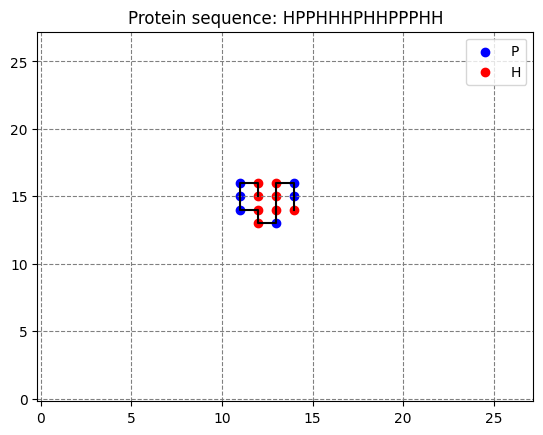

In [12]:
grid_size = 2*n - 1
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, reduced=False)
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

## Alternatives

### Reduced number of variables

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpdis82csx.pyomo.lp
Reading time = 0.02 seconds
x625633: 4354 rows, 11363 columns, 41720 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 4354 rows, 11363 columns and 41720 nonzeros
Model fingerprint: 0xfad64823
Variable types: 1 continuous, 11362 integer (11362 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6.0000000
Presolve removed 2222 rows and 9691 columns
Presolve time: 0.47s
Presolved: 2132 rows, 1672 columns, 10569 nonzeros
Variable types: 0 continuous, 1672 integer (1672 binary)

Root relaxation: objective 1

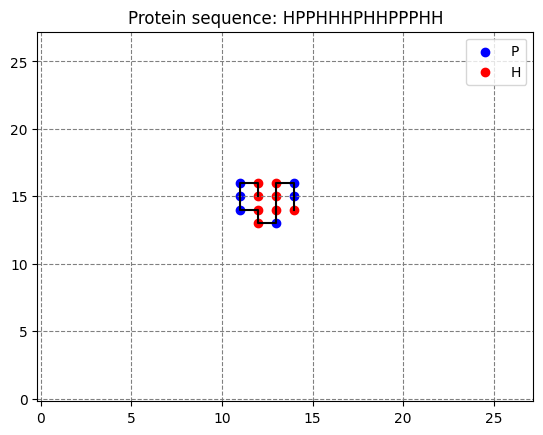

In [13]:
grid_size = 2*n - 1
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, reduced=True)
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

### Another way : reduce the grid

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpwj9bzldc.pyomo.lp
Reading time = 0.01 seconds
x103636: 5614 rows, 5005 columns, 39053 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 5614 rows, 5005 columns and 39053 nonzeros
Model fingerprint: 0x169ca90e
Variable types: 1 continuous, 5004 integer (5004 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 5.0000000
Presolve removed 3623 rows and 3576 columns
Presolve time: 0.34s
Presolved: 1991 rows, 1429 columns, 8501 nonzeros
Variable types: 0 continuous, 1429 integer (1429 binary)

Root relaxation: objective 1.2820

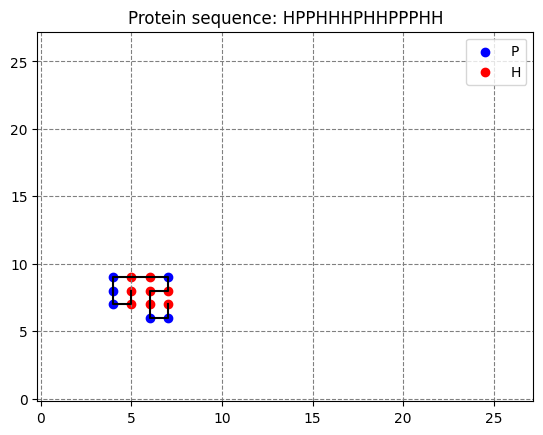

In [6]:
import networkx as nx

def ILP_graph_formulation_reduced_grid(binary_seq):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    p = int(n/2)

    # Set of indices
    model.K = RangeSet(0, n - 1)    # set of indexes in sequence 
    model.K1 = RangeSet(0, n - 2)
    model.I = RangeSet(n - p, 2*n - 1) 
    model.J = RangeSet(n - p, n + p)
    model.H = Set(initialize=get_hydrophobic_set(binary_seq))   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision Variables
    model.x = Var(model.K, model.I, model.J, within=Binary)
    model.y = Var(model.I, model.J, model.I, model.J, within=Binary)

    G = nx.Graph()

    n = len(binary_seq)

    # add nodes
    for i in model.I:
        for j in model.J:
                G.add_node( (i, j) )

    # add edges
    for i, j in G.nodes():
         for u, v in G.nodes():
              if is_adjacent(i, j, u, v):
                   G.add_edge( (i, j), (u, v) )

    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    # the first amino acid is placed on the center of the grid (n,n)
    model.constraints.add(expr = ( model.x[0, n, n] == 1 ) )

    # each vertex has at most one amino acid
    for i in model.I:
        for j in model.J:
            model.constraints.add(expr = ( sum( model.x[k, i, j] for k in model.K ) <= 1 ) )
        
    # each amino acid is placed at exactly one vertex
    for k in model.K:
        model.constraints.add(expr = ( sum( model.x[k, i, j] for i in model.I for j in model.J ) == 1 ) )

    # if amino acid k is placed at (i, j) then amino acid k+1 is placed at a vertex (u, v) adjacent
    # to vertex (i, j)
    for k in model.K1:
        for i in model.I:
            for j in model.J:
                try:
                    model.constraints.add(expr = ( model.x[k, i, j] <= sum( model.x[k+1, u, v] for (u, v) in G[(i,j)] ) ) )
                except:
                    # if node is not in edges
                    pass
    

    # we want y[i, j ,u, v]=1 only if an H amino acid is placed at (i,j) and another amino acid H is placed at a neighboring vertex
    for ((i, j), (u, v)) in G.edges():
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, i, j] for k in model.H ) ) )
        model.constraints.add(expr = ( model.y[i, j, u, v] <= sum( model.x[k, u, v] for k in model.H ) ) )


    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.y[i, j, u, v] for ((i, j), (u, v)) in G.edges() ) ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", ) 
    else:
        print('Error in solving the model')
    
    return [[[model.x[k, i, j]() for j in model.J] for i in model.I] for k in model.K]


grid_size = 2*n - 1
x = ILP_graph_formulation_reduced_grid(protein_binary_sequence)
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

### Alternative formulation

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpqnxzugr4.pyomo.lp
Reading time = 0.01 seconds
x53776: 1969 rows, 3333 columns, 15674 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1969 rows, 3333 columns and 15674 nonzeros
Model fingerprint: 0x3920c7cd
Variable types: 1 continuous, 3332 integer (3332 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.02s
Presolved: 1968 rows, 3332 columns, 15673 nonzeros
Variable types: 0 continuous, 3332 integer (3332 binary)

Root relaxation: objective 1.411765e+0

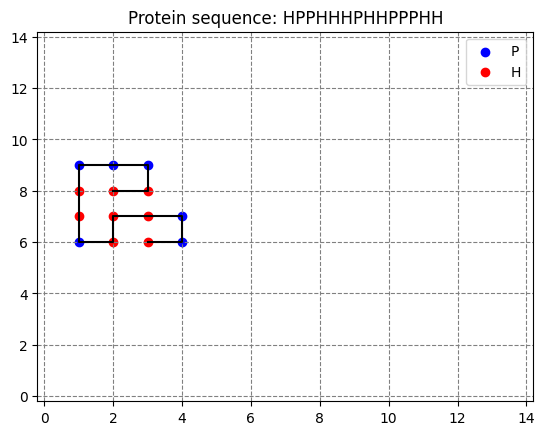

In [14]:
# No reduction of variables

grid_size = n
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, reduced=False, formulation="alternative")
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmpx88rc406.pyomo.lp
Reading time = 0.00 seconds
x69121: 1313 rows, 3690 columns, 12621 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1313 rows, 3690 columns and 12621 nonzeros
Model fingerprint: 0x8489be80
Variable types: 1 continuous, 3689 integer (3689 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.01s
Presolved: 1312 rows, 3689 columns, 12620 nonzeros
Variable types: 0 continuous, 3689 integer (3689 binary)

Root relaxation: objective 1.350000e+0

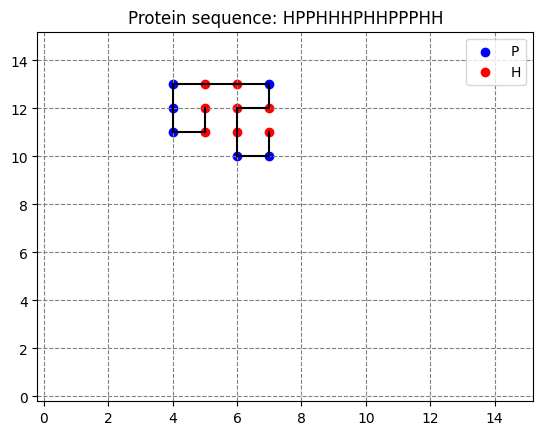

In [15]:
# We increase the grid to (n+1)x(n+1) and we simplify in an analogous way to the original formulation

grid_size = n+1
x = ILP_graph_formulation(protein_binary_sequence, grid_size, additional_constr=False, reduced=True, formulation="alternative")
positions = grid_positions_from_optimal(x)
plot_folding(protein_binary_sequence, protein_sequence, positions, grid_size)